# Admissão de Aluno
In this notebook, we predict student admissions to graduate school at UCLA based on three pieces of data:
- GRE Scores (Graduate Record Examination)
- GPA Scores (Grade Point Average)
- Class rank (1-4)

In [16]:
# Importing pandas and numpy
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

## Importando a base de dados

In [4]:
data = pd.read_csv('../data/student_data.csv')
#Mostrando as primeiras 5 linhas da tabela
data.head()

,admit,gre,gpa,rank
0,0,380,3.61,3
1,1,660,3.67,3
2,1,800,4.00,1
3,1,640,3.19,4
4,0,520,2.93,4


## Gráfico de dispersão

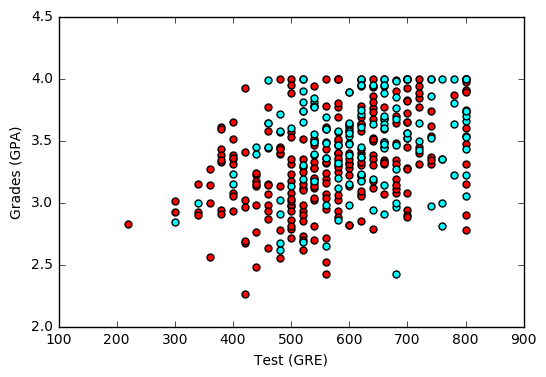

In [5]:
def plot_points(data):
    X = np.array(data[["gre","gpa"]])
    y = np.array(data["admit"])
    admitted = X[np.argwhere(y==1)]
    rejected = X[np.argwhere(y==0)]
    plt.scatter([s[0][0] for s in rejected], [s[0][1] for s in rejected], s = 25, color = 'red', edgecolor = 'k')
    plt.scatter([s[0][0] for s in admitted], [s[0][1] for s in admitted], s = 25, color = 'cyan', edgecolor = 'k')
    plt.xlabel('Test (GRE)')
    plt.ylabel('Grades (GPA)')
    
plot_points(data)

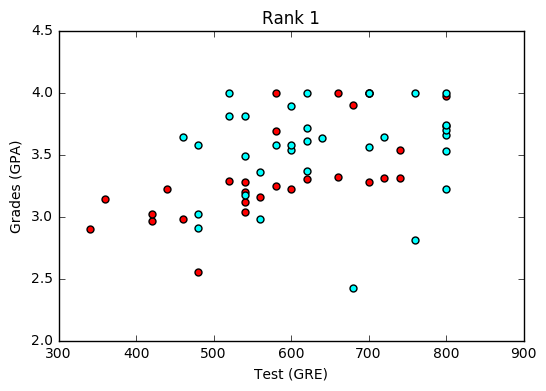

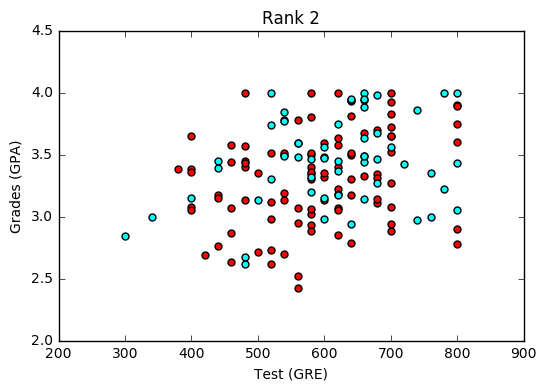

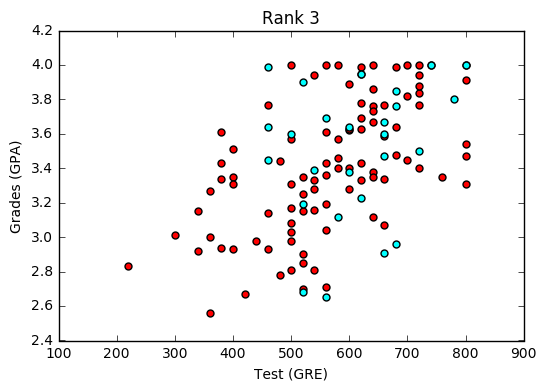

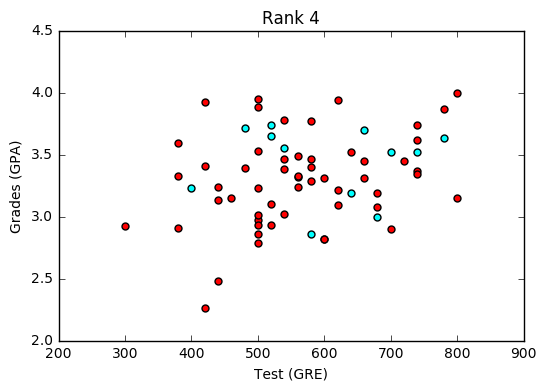

In [8]:
for i in range(1,5):
    plot_points(data.query("rank == {}".format(i)))
    plt.title("Rank {}".format(i))
    plt.show()

## Aplicando one-hot no rank (criação de variável dummy)

In [10]:
one_hot_data = pd.concat([data, pd.get_dummies(data['rank'], prefix='rank')], axis=1)

one_hot_data = one_hot_data.drop('rank', axis=1)

one_hot_data.head(10)

,admit,gre,gpa,rank_1,rank_2,rank_3,rank_4
0,0,380,3.61,0.0,0.0,1.0,0.0
1,1,660,3.67,0.0,0.0,1.0,0.0
2,1,800,4.00,1.0,0.0,0.0,0.0
3,1,640,3.19,0.0,0.0,0.0,1.0
4,0,520,2.93,0.0,0.0,0.0,1.0
5,1,760,3.00,0.0,1.0,0.0,0.0
6,1,560,2.98,1.0,0.0,0.0,0.0
7,0,400,3.08,0.0,1.0,0.0,0.0
8,1,540,3.39,0.0,0.0,1.0,0.0
9,0,700,3.92,0.0,1.0,0.0,0.0


## TODO: Scaling the data
The next step is to scale the data. We notice that the range for grades is 1.0-4.0, whereas the range for test scores is roughly 200-800, which is much larger. This means our data is skewed, and that makes it hard for a neural network to handle. Let's fit our two features into a range of 0-1, by dividing the grades by 4.0, and the test score by 800.

In [12]:
processed_data = one_hot_data[:]
max_gre = processed_data["gre"].max()
max_gpa = processed_data["gpa"].max() 
print("Máximo gpa: {} / Máximo gre: {}".format(max_gpa, max_gre))

Máximo gpa: 4.0 / Máximo gre: 800


In [13]:
processed_data['gre'] = processed_data['gre']/max_gre
processed_data['gpa'] = processed_data['gpa']/max_gpa
processed_data.head(10)

,admit,gre,gpa,rank_1,rank_2,rank_3,rank_4
0,0,0.475,0.9025,0.0,0.0,1.0,0.0
1,1,0.825,0.9175,0.0,0.0,1.0,0.0
2,1,1.000,1.0000,1.0,0.0,0.0,0.0
3,1,0.800,0.7975,0.0,0.0,0.0,1.0
4,0,0.650,0.7325,0.0,0.0,0.0,1.0
5,1,0.950,0.7500,0.0,1.0,0.0,0.0
6,1,0.700,0.7450,1.0,0.0,0.0,0.0
7,0,0.500,0.7700,0.0,1.0,0.0,0.0
8,1,0.675,0.8475,0.0,0.0,1.0,0.0
9,0,0.875,0.9800,0.0,1.0,0.0,0.0


## Treino e Teste

In [14]:
sample = np.random.choice(processed_data.index, size=int(len(processed_data)*0.9), replace=False)

train_data, test_data = processed_data.iloc[sample], processed_data.drop(sample)

print("Treino #:", len(train_data))
print("Teste #:", len(test_data))
print(train_data.shape)
print(test_data.shape)

Treino #: 360
Teste #: 40
(360, 7)
(40, 7)


## Features e Labels

In [15]:
features = train_data.drop('admit', axis=1)
targets = train_data['admit']
features_test = test_data.drop('admit', axis=1)
targets_test = test_data['admit']

print(features.shape)
print(targets.shape)

(360, 6)
(360,)


$$ \sigma'(x) = \sigma(x)*(1-\sigma(x))$$
$$ \tanh'(x) = 1 - tanh^2(x)$$


In [26]:
class Activation():
    def __init__(self):
        pass
    
    def f_activ_sig(self, x):
        return 1 / (1 + np.exp(-x))

    def f_activ_sig_prime(self, x):
        return self.f_activ_sig(x)*(1-self.f_activ_sig(x))
    
    def f_activ_relu(self, x):
        return (abs(x) + x)/2

    def f_activ_relu_prime(self, x):
        return np.where(x > 0, 1.0, 0.0)

    def f_ident(self, x):
        return x
    
    def f_ident_prime(self, x):
        return np.ones_like(x)
    
    def f_tanh(self, x):
        return np.tanh(x)
    
    def f_tanh_prime(self, x):
        return 1 - np.tanh(x)**2
    
    def softmax(self, x):
        if x.ndim != 1:
            return np.exp(x) / np.sum(np.exp(x), axis = 1)[:, None]
        else:
            return np.exp(x) / np.sum(np.exp(x), axis = 0)
    
    def softmax_prime(self, x):
        s = self.softmax(x).reshape(-1,1)
        return np.diag(np.diagflat(s) - np.dot(s, s.T))
    
class Layer():
    def __init__(self, neurons, type_, activation="relu"):
        activ = Activation()
        self.neurons = neurons
        self.type_ = type_
        self.activation_name = activation
        if type_ == "input":
            self.activation = activ.f_ident
            self.activation_prime = activ.f_ident_prime
            self.activation_name = "ident"
        elif activation == "relu":
            self.activation = activ.f_activ_relu
            self.activation_prime = activ.f_activ_relu_prime
        elif activation == "tanh":
            self.activation = activ.f_tanh
            self.activation_prime = activ.f_tanh_prime
        elif activation == "ident":
            self.activation = activ.f_ident
            self.activation_prime = activ.f_ident_prime   
        elif activation == "softmax":
            self.activation = activ.softmax
            self.activation_prime = activ.softmax_prime               
        else:
            self.activation = activ.f_activ_sig
            self.activation_prime = activ.f_activ_sig_prime

In [27]:
class MLP():
    def __init__(self, layers):
        self.layers = {k: item for k, item in enumerate(layers)}
        
        self.weights = dict()
        self.biases = dict()       
        
        init_ = 0
        end_ = len(self.layers)
        
        for i, k in zip(range(0,end_-1), range(init_+1, end_)):
            dim_1 = self.layers[i].neurons
            dim_2 = self.layers[k].neurons
            self.weights[k] = np.random.normal(0, dim_1 ** -.5,
                                        size=(dim_1, dim_2))
            
            self.biases[k] = np.zeros(dim_2)
    
    def summary(self):
        for k, layer in self.layers.items():
            print("Layer {} - {} com {} neurônios e funcão de ativação {}".format(layer.type_,
                                                                                  k, layer.neurons, layer.activation_name))
            
        for k, weight in self.weights.items():
            print("Shape matriz {} = {} / Shape bias {} = {}". format(k, weight.shape, k, self.biases[k].shape))
            
    def forward(self, x):
        input_ = x
        
        hidden = dict()
        primes = dict()
        
        init_ = 0
        end_ = len(self.layers)
        
        for i, k in zip(range(0,end_-1), range(init_+1, end_)):
            dot_product = np.dot(input_, self.weights[k]) + self.biases[k]
            hidden[k] = self.layers[k].activation(dot_product)
            primes[k] = self.layers[k].activation_prime(dot_product)
            input_ = hidden[k]    
            
        return hidden, primes
    
    def init_steps(self):
        steps = dict()
        biases_steps=dict()
        for k in range(1, len(self.layers), 1):
            steps[k] = np.zeros((self.weights[k].shape[0], self.weights[k].shape[1]))
            biases_steps[k] = np.zeros(self.weights[k].shape[1])    
        
        return steps, biases_steps
    
    def train(self, X, Y, batch, epochs=1000, learnrate=0.5):
        last_loss = None
        for e in range(epochs):
            steps, biases_steps = self.init_steps()
            for x, y in zip(X, Y):
                hidden, primes = self.forward(x)
                
                error_term = dict()
                                
                init_ = len(self.layers) - 1 
                end_ = 0
                
                for k in range(init_, 0, -1):
                    if k == init_:
                        error = -(y-hidden[k])
                    else:
                        error = np.dot(error_term[k+1], self.weights[k+1].T)
                        
                    error_term[k] =error*primes[k]
                    
                    if k != end_ + 1:
                        steps[k] += error_term[k]*hidden[k-1][:, None]

                    else:
                        steps[k] += error_term[k]*x[:, None]
                        

                    biases_steps[k] += error_term[k]
                    
            for k in range(1, len(self.layers), 1):
                self.weights[k] -= learnrate*steps[k] / len(X)    
                self.biases[k] -= learnrate*biases_steps[k] / len(X)
            
            if e % (epochs / 10) == 0:
                input_ = X
                for k in range(1, len(self.layers), 1):
                    output_ = self.layers[k].activation(np.dot(input_, self.weights[k]) + self.biases[k])
                    input_ = output_

                loss_f = np.mean((output_ - Y) ** 2)
                
                
                if last_loss and last_loss < loss_f:
                    print("Train loss: ", loss_f, "  WARNING - Loss Increasing")
                else:
                    print("Train loss: ", loss_f)
                last_loss = loss_f

    def predict(self, X):
        input_ = X
        for k in range(1, len(self.layers), 1):
            output_ = self.layers[k].activation(np.dot(input_, self.weights[k]) + self.biases[k])
            input_ = output_
            
        return output_

In [28]:
list_layers = list()
list_layers.append(Layer(784, "input"))
list_layers.append(Layer(256, "hidden", "tanh"))
list_layers.append(Layer(256, "hidden", "relu"))
list_layers.append(Layer(10, "output", "softmax"))
model = MLP(list_layers)

In [369]:
new_target = np.c_[targets.values, np.ones(len(targets.values))]
new_target[:,1] = new_target[:,1] - new_target[:,0]
new_target[0:5]

array([[ 1.,  0.],
       [ 0.,  1.],
       [ 0.,  1.],
       [ 0.,  1.],
       [ 0.,  1.]])

In [29]:
model.summary()

Layer input - 0 com 784 neurônios e funcão de ativação ident
Layer hidden - 1 com 256 neurônios e funcão de ativação tanh
Layer hidden - 2 com 256 neurônios e funcão de ativação relu
Layer output - 3 com 10 neurônios e funcão de ativação softmax
Shape matriz 1 = (784, 256) / Shape bias 1 = (256,)
Shape matriz 2 = (256, 256) / Shape bias 2 = (256,)
Shape matriz 3 = (256, 10) / Shape bias 3 = (10,)


In [52]:
model.train(mnist.train.images[0:1000], mnist.train.labels[0:1000], 10, epochs=10, learnrate=0.3)

Train loss:  0.0223482238454
Train loss:  0.0222642035819
Train loss:  0.0221792134192
Train loss:  0.0220941586193
Train loss:  0.0220082728193
Train loss:  0.0219219220229
Train loss:  0.0218353873242
Train loss:  0.0217479350806
Train loss:  0.0216605155572
Train loss:  0.0215726318407


In [34]:
model.show_acc(mnist.train.images[0:500],  mnist.train.labels[0:500])

Prediction accuracy Train: 0.905


In [40]:
a = np.array([[1,2,3,4]])

In [41]:
a.argmax()

3

3 5


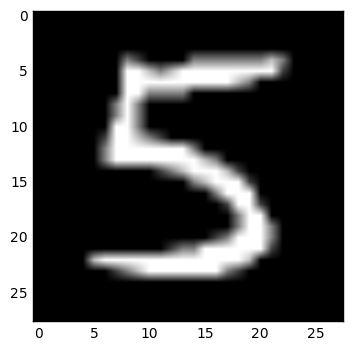

6 6


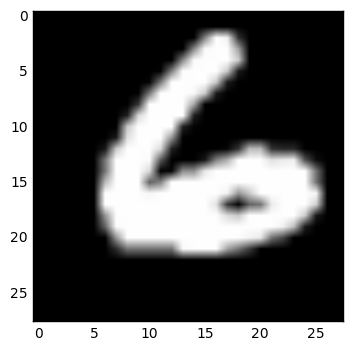

9 7


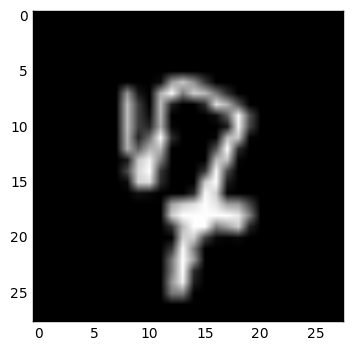

8 8


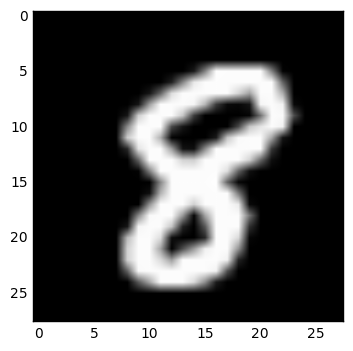

2 2


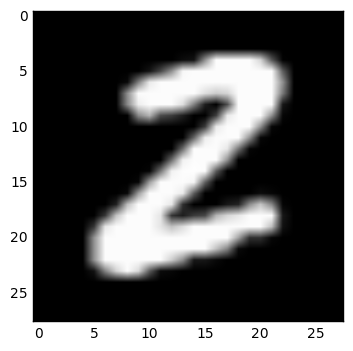

9 9


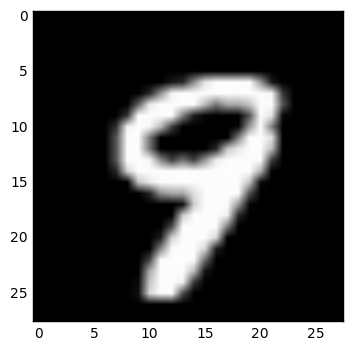

1 1


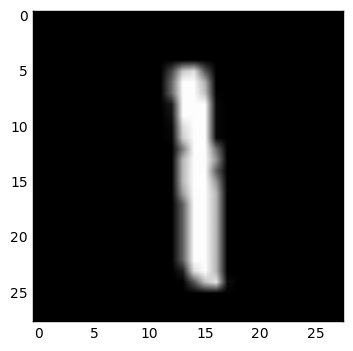

0 0


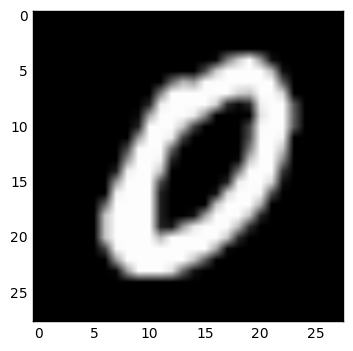

1 1


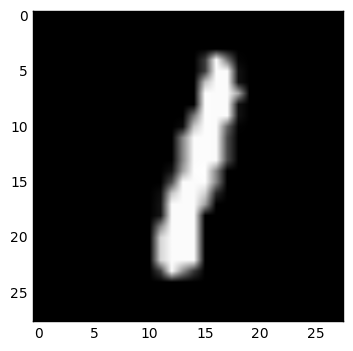

1 1


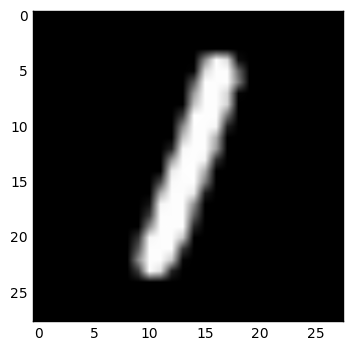

4 4


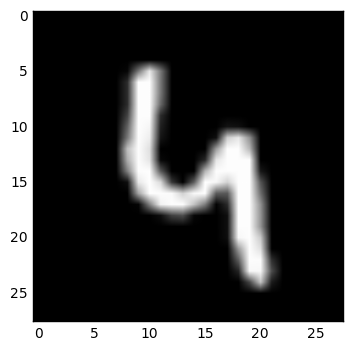

2 2


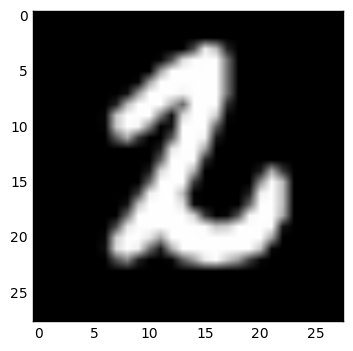

2 2


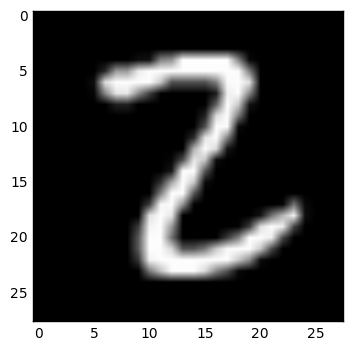

3 3


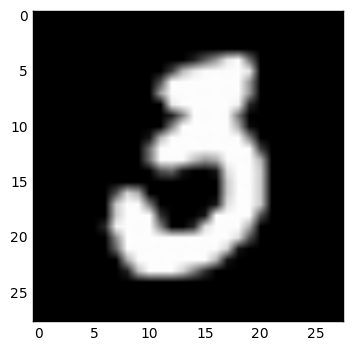

9 8


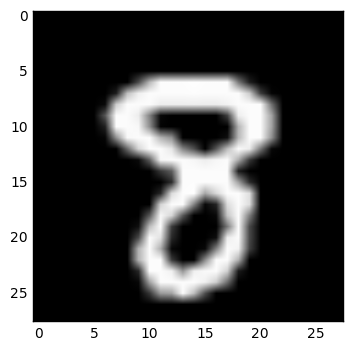

4 4


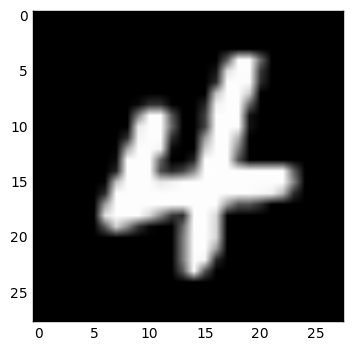

3 3


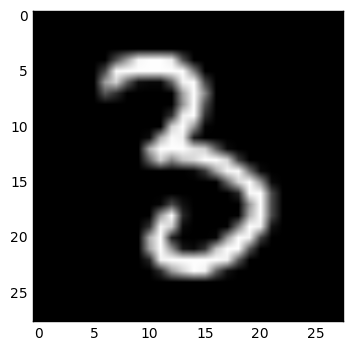

0 5


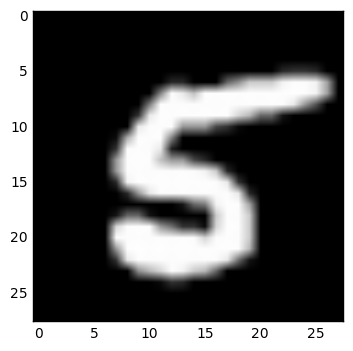

4 4


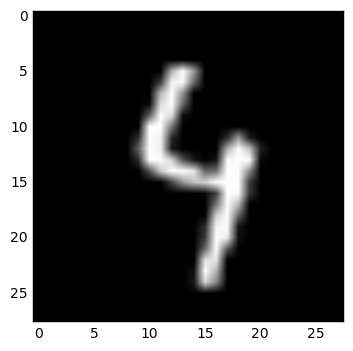

6 6


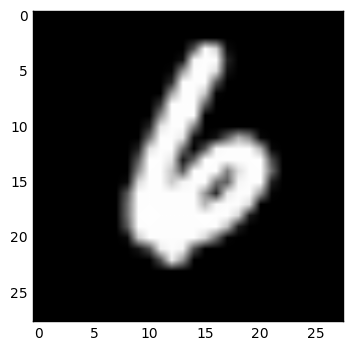

In [50]:
for i in range(1200,1220):
    print(model.predict(mnist.train.images[i:i+1]).argmax(), mnist.train.labels[i:i+1].argmax())
    plt.imshow(mnist.train.images[i:i+1].reshape((28,28)), cmap="gray")
    plt.show()

In [375]:
# Compute ROC curve and ROC area for each class
from sklearn.metrics import roc_curve, auc
y_score = model.predict(features.values)
y_test = new_target
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(2):
    fpr[i], tpr[i], _ = roc_curve(y_test[:, i], y_score[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Compute micro-average ROC curve and ROC area
fpr["micro"], tpr["micro"], _ = roc_curve(y_test.ravel(), y_score.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

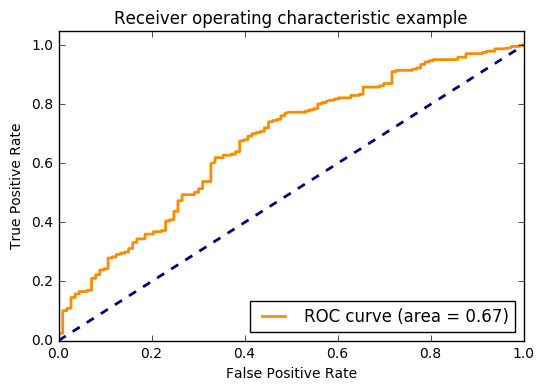

In [381]:
plt.figure()
lw = 2
plt.plot(fpr[0], tpr[0], color='darkorange',
         lw=lw, label='ROC curve (area = %0.2f)' % roc_auc[0])
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic example')
plt.legend(loc="lower right")

Average precision score, micro-averaged over all classes: 0.75


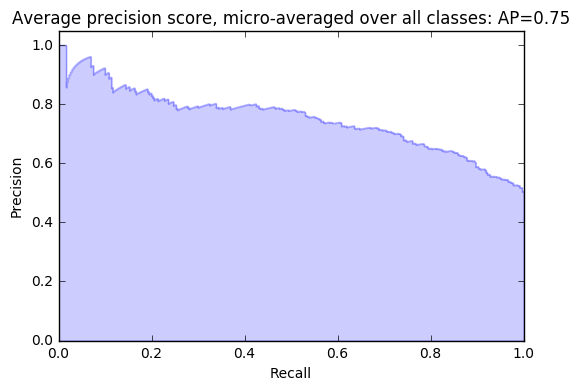

In [386]:
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import average_precision_score
from sklearn.utils.fixes import signature
# For each class
precision = dict()
recall = dict()
average_precision = dict()
step_kwargs = ({'step': 'post'}
               if 'step' in signature(plt.fill_between).parameters
               else {})

for i in range(2):
    precision[i], recall[i], _ = precision_recall_curve(y_test[:, i],
                                                        y_score[:, i])
    average_precision[i] = average_precision_score(y_test[:, i], y_score[:, i])

# A "micro-average": quantifying score on all classes jointly
precision["micro"], recall["micro"], _ = precision_recall_curve(y_test.ravel(),
    y_score.ravel())
average_precision["micro"] = average_precision_score(y_test, y_score,
                                                     average="micro")
print('Average precision score, micro-averaged over all classes: {0:0.2f}'
      .format(average_precision["micro"]))

plt.figure()
plt.step(recall['micro'], precision['micro'], color='b', alpha=0.2,
         where='post')
plt.fill_between(recall["micro"], precision["micro"], alpha=0.2, color='b', **step_kwargs)

plt.xlabel('Recall')
plt.ylabel('Precision')
plt.ylim([0.0, 1.05])
plt.xlim([0.0, 1.0])
plt.title(
    'Average precision score, micro-averaged over all classes: AP={0:0.2f}'
    .format(average_precision["micro"]))

In [1]:
from tensorflow.examples.tutorials.mnist import input_data
mnist = input_data.read_data_sets("/tmp/data/", one_hot=True)

Instructions for updating:
Please use alternatives such as official/mnist/dataset.py from tensorflow/models.
Instructions for updating:
Please write your own downloading logic.
Instructions for updating:
Please use urllib or similar directly.
Successfully downloaded train-images-idx3-ubyte.gz 9912422 bytes.
Instructions for updating:
Please use tf.data to implement this functionality.
Extracting /tmp/data/train-images-idx3-ubyte.gz
Successfully downloaded train-labels-idx1-ubyte.gz 28881 bytes.
Instructions for updating:
Please use tf.data to implement this functionality.
Extracting /tmp/data/train-labels-idx1-ubyte.gz
Instructions for updating:
Please use tf.one_hot on tensors.
Successfully downloaded t10k-images-idx3-ubyte.gz 1648877 bytes.
Extracting /tmp/data/t10k-images-idx3-ubyte.gz
Successfully downloaded t10k-labels-idx1-ubyte.gz 4542 bytes.
Extracting /tmp/data/t10k-labels-idx1-ubyte.gz
Instructions for updating:
Please use alternatives such as official/mnist/dataset.py from t

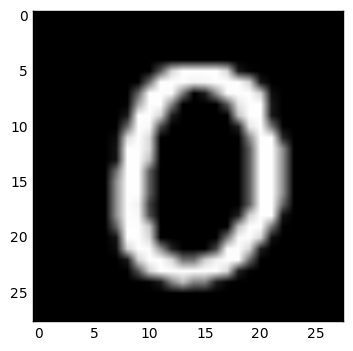

In [25]:
plt.imshow(mnist.train.images[10].reshape((28,28))/256, cmap="gray")

In [ ]:
from __future__ import print_function

# Import MNIST data
from tensorflow.examples.tutorials.mnist import input_data
mnist = input_data.read_data_sets("/tmp/data/", one_hot=True)

import tensorflow as tf

# Parameters
learning_rate = 0.001
training_epochs = 15
batch_size = 100
display_step = 1

# Network Parameters
n_hidden_1 = 256 # 1st layer number of neurons
n_hidden_2 = 256 # 2nd layer number of neurons
n_input = 784 # MNIST data input (img shape: 28*28)
n_classes = 10 # MNIST total classes (0-9 digits)

# tf Graph input
X = tf.placeholder("float", [None, n_input])
Y = tf.placeholder("float", [None, n_classes])

# Store layers weight & bias
weights = {
    'h1': tf.Variable(tf.random_normal([n_input, n_hidden_1])),
    'h2': tf.Variable(tf.random_normal([n_hidden_1, n_hidden_2])),
    'out': tf.Variable(tf.random_normal([n_hidden_2, n_classes]))
}
biases = {
    'b1': tf.Variable(tf.random_normal([n_hidden_1])),
    'b2': tf.Variable(tf.random_normal([n_hidden_2])),
    'out': tf.Variable(tf.random_normal([n_classes]))
}


# Create model
def multilayer_perceptron(x):
    # Hidden fully connected layer with 256 neurons
    layer_1 = tf.add(tf.matmul(x, weights['h1']), biases['b1'])
    # Hidden fully connected layer with 256 neurons
    layer_2 = tf.add(tf.matmul(layer_1, weights['h2']), biases['b2'])
    # Output fully connected layer with a neuron for each class
    out_layer = tf.matmul(layer_2, weights['out']) + biases['out']
    return out_layer

# Construct model
logits = multilayer_perceptron(X)

# Define loss and optimizer
loss_op = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(
    logits=logits, labels=Y))
optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate)
train_op = optimizer.minimize(loss_op)
# Initializing the variables
init = tf.global_variables_initializer()

with tf.Session() as sess:
    sess.run(init)

    # Training cycle
    for epoch in range(training_epochs):
        avg_cost = 0.
        total_batch = int(mnist.train.num_examples/batch_size)
        # Loop over all batches
        for i in range(total_batch):
            batch_x, batch_y = mnist.train.next_batch(batch_size)
            # Run optimization op (backprop) and cost op (to get loss value)
            _, c = sess.run([train_op, loss_op], feed_dict={X: batch_x,
                                                            Y: batch_y})
            # Compute average loss
            avg_cost += c / total_batch
        # Display logs per epoch step
        if epoch % display_step == 0:
            print("Epoch:", '%04d' % (epoch+1), "cost={:.9f}".format(avg_cost))
    print("Optimization Finished!")

    # Test model
    pred = tf.nn.softmax(logits)  # Apply softmax to logits
    correct_prediction = tf.equal(tf.argmax(pred, 1), tf.argmax(Y, 1))
    # Calculate accuracy
    accuracy = tf.reduce_mean(tf.cast(correct_prediction, "float"))
    print("Accuracy:", accuracy.eval({X: mnist.test.images, Y: mnist.test.labels}))